# Classificador MLP
O desenvolvimento do classificador será dividido em três etapas distintas:

1. Pré-processamento e seleção de atributos
2. Busca por hiperparâmetros com validação cruzada
3. Treinamento e teste da MLP

## Pré-processamento
Nesta etapa será feita a seleção das colunas que carregam informações relevantes ao treinamento e a codificação do conteúdo do dataset. Diversas filtragens serão utilizadas a fim de diminuir a dimensão do dataset.

In [402]:
input_cols = [
    'SG_UF_RESIDENCIA', 'NU_IDADE', 'TP_SEXO',
    'TP_COR_RACA', 'TP_NACIONALIDADE', 'SG_UF_NASCIMENTO', 
    'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO', 'IN_TREINEIRO',
    'IN_BAIXA_VISAO', 'IN_CEGUEIRA', 'IN_SURDEZ', 'IN_DEFICIENCIA_AUDITIVA', 'IN_SURDO_CEGUEIRA',
    'IN_DEFICIENCIA_FISICA', 'IN_DEFICIENCIA_MENTAL', 'IN_DEFICIT_ATENCAO', 'IN_DISLEXIA',
    'IN_DISCALCULIA', 'IN_AUTISMO', 'IN_VISAO_MONOCULAR', 'IN_OUTRA_DEF',
    'IN_ESTUDA_CLASSE_HOSPITALAR', 'IN_SEM_RECURSO',
    'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT',
    'Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q007', 'Q024', 'Q025', 'Q026', 'Q027']

output_cols = ['NU_NOTA_REDACAO','NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT']

In [403]:
import os
import pandas
import numpy as np
import seaborn as sb
import zipfile

%matplotlib inline
import matplotlib.pyplot as plt

from os.path import abspath, join

root_dir = abspath('..')
dataset_dir = join(root_dir, 'dataset')
# set dataset files path
file_path = join(dataset_dir, 'microdados_enem2018.zip')
# read zip files
zf = zipfile.ZipFile(file_path)
data = pandas.read_csv(zf.open('DADOS/MICRODADOS_ENEM_2018.csv'),
                       sep=';', encoding='cp1252', usecols=input_cols + output_cols)\
            .dropna()

### DADOS DO QUESTIONÁRIO SOCIOECONÔMICO
O questionário socioeconômico possui informações categóricas que serão codificadas através do one-hot-encoding. Em casos especiais que a resposta é binária, os dados serão mapeados em 0 e 1. Abaixo é descrita a natureza dos dados de cada coluna do questionário:

|Coluna|Valores |Codificação|
|:----:|:----:|:-----------:|
|Q001,Q002|A-H|One-hot-encoding|
|Q003,Q004|                  A-F|One-hot-encoding|
|Q005|                       1-20 (Numérico)|nenhum|
|Q006|                       A-Q|One-hot-encoding|
|Q007,Q026|                  A-D|One-hot-encoding|
|Q008-17,Q019,Q022,Q024|     A-E|One-hot-encoding|
|Q018,Q020-21,Q023,Q025|     A-B |(Codificação A=0, B=1)|
|Q027|                       A-F|One-hot-encoding|


In [404]:
one_hot_socio = ['Q001','Q002','Q003','Q004','Q006',
         'Q007','Q008','Q009','Q010','Q011','Q012','Q013','Q014',
         'Q015','Q016','Q017','Q019','Q022','Q024','Q026','Q027',
        ]
encode_socio = {
    'Q018':{'A':0,'B':1},
    'Q020':{'A':0,'B':1},
    'Q021':{'A':0,'B':1},
    'Q023':{'A':0,'B':1},
    'Q025':{'A':0,'B':1}}

#### Filtragem
A alternativa "Não sei." das questões Q001, Q002, Q003 e Q004 a princípio não traz tanta informação a cerca da situação socioeconômica do candidato. Devido aos recursos computacionais limitados, tais linhas do dataset serão eliminadas.

|Coluna|Opção "Não sei."|
|:----:|:----:|
|Q001|H|
|Q002|H|
|Q003|F|
|Q004|F|

In [405]:
print('Antes {}'.format(data.shape))
data.drop(data[(data['Q001']=="H") | (data['Q002']=="H")|(data['Q003']=="F") | (data['Q004']=="F")].index, inplace=True)

from sklearn.preprocessing import StandardScaler
Q005_scaler = StandardScaler()
data['Q005'] = Q005_scaler.fit_transform(data['Q005'].to_numpy().reshape(-1,1))

print('Depois {}'.format(data.shape))

Antes (2318389, 46)
Depois (1812629, 46)


Com a aplicação dos filtros descritos, o dataset teve a seguinte redução de dimensionalidade:

|     |Linhas|Colunas|
|:---:|:----:|:-----:|
|Antes|2318389|46|
|Depois|1812629|46|

### DADOS DO PARTICIPANTE

Serão utilizadas as seguintes informações referentes ao participante:

|Coluna|Descrição|
|:----:|:---------|
|NU_IDADE|	Idade|
|TP_SEXO|	Sexo|
|TP_ESTADO_CIVIL|	Estado Civil|
|TP_COR_RACA|	Cor/raça|
|TP_NACIONALIDADE|	Nacionalidade|
|TP_ST_CONCLUSAO|	Situação de conclusão do Ensino Médio|
|TP_ANO_CONCLUIU|	Ano de Conclusão do Ensino Médio 1-12|
|TP_ESCOLA|	Tipo de escola do Ensino Médio 1-4|
|TP_ENSINO|	Tipo de instituição que concluiu ou concluirá o Ensino Médio 1-3|
|IN_TREINEIRO|	Indica se o inscrito fez a prova com intuito de apenas treinar seus conhecimentos 0-1|

Para diminuir a matriz final, as seguintes colunas foram ignoradas:

|Coluna|Descrição|
|:----:|:---------|
|NO_MUNICIPIO_RESIDENCIA|	Nome do município de residência|
|NO_MUNICIPIO_NASCIMENTO|	Nome do município de nascimento|
|SG_UF_NASCIMENTO|	Sigla da Unidade da Federação de nascimento|

Serão avaliados apenas participantes do estado de São Paulo.

|Coluna|Valor|
|:----:|:---------|
|SG_UF_RESIDENCIA|SP|

In [406]:
one_hot_participante = [
    'TP_ESTADO_CIVIL','TP_COR_RACA',
    'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO','TP_ANO_CONCLUIU',
    'TP_ESCOLA','TP_ENSINO','IN_TREINEIRO'
]

encode_participante = {'TP_SEXO':{'M':0, 'F':1}}

from sklearn.preprocessing import StandardScaler
idade_scaler = StandardScaler()
data['NU_IDADE'] = idade_scaler.fit_transform(data['NU_IDADE'].to_numpy().reshape(-1,1))

#### Filtragem
Informações referentes aos municípios serão removidas pois ao serem codificadas pelo one-hot-encode produzem matrizes de dimensões elevadas.

Serão removidos do dataset linhas que não trazem informações relevantes ao classificados, tais como:

|Coluna|Valor|Descrição|
|:----:|:---:|:-------:|
|TP_NACIONALIDADE|0|Não informado|

Todos os participantes que fizeram a prova para treinar os conhecimentos serão removidos do dataset:

|Coluna|Valor|Descrição|
|:----:|:---:|:-------:|
|IN_TREINEIRO|1|Indica se o inscrito fez a prova com intuito de apenas treinar seus conhecimentos.|




In [407]:
print('Antes {}'.format(data.shape))

if 'NO_MUNICIPIO_RESIDENCIA' in data.columns:
    data.drop(['NO_MUNICIPIO_RESIDENCIA'], axis=1, inplace=True)

if 'NO_MUNICIPIO_NASCIMENTO' in data.columns:
    data.drop(['NO_MUNICIPIO_NASCIMENTO'], axis=1, inplace=True)

if 'IN_TREINEIRO' in data.columns:
    data.drop(data[data['IN_TREINEIRO']==1].index, inplace=True)
    data.drop(['IN_TREINEIRO'], axis=1, inplace=True)

if 'SG_UF_RESIDENCIA' in data.columns:
    data.drop(data[data['SG_UF_RESIDENCIA']!="SP"].index, inplace=True)
    data.drop(['SG_UF_RESIDENCIA'], axis=1, inplace=True)

if 'SG_UF_NASCIMENTO' in data.columns:
    data.drop(['SG_UF_NASCIMENTO'], axis=1, inplace=True)

data.drop(data[(data['TP_NACIONALIDADE']==0)].index, inplace=True)    
print('Depois {}'.format(data.shape))
    


Antes (1812629, 46)
Depois (289542, 43)


Com a aplicação dos filtros descritos, o dataset teve a seguinte redução de dimensionalidade:

|     |Linhas|Colunas|
|:---:|:----:|:-----:|
|Antes|1812629|46|
|Depois|289542|43|

### Recursos Especializados
#### Filtragem

Removida as colunas por não trazerem informações relevantes:

|Coluna|Descrição|
|:----:|:-------:|
|IN_SEM_RECURSO|Indicador de inscrito que não requisitou nenhum recurso|



In [408]:
print('Antes {}'.format(data.shape))
if 'IN_SEM_RECURSO' in data.columns:
    data.drop(['IN_SEM_RECURSO'], axis=1, inplace=True)
print('Depois {}'.format(data.shape))

Antes (289542, 43)
Depois (289542, 42)


Com a aplicação dos filtros descritos, o dataset teve a seguinte redução de dimensionalidade:

|     |Linhas|Colunas|
|:---:|:----:|:-----:|
|Antes|1812629|43|
|Depois|289542|42|

### DADOS DA PROVA OBJETIVA

Participantes considerados ausentes serão descartados.

|Coluna|Descrição|
|:-----:|:------:|
|TP_PRESENCA_CN|	Presença na prova objetiva de Ciências da Natureza|
|TP_PRESENCA_CH|	Presença na prova objetiva de Ciências Humanas|
|TP_PRESENCA_LC|	Presença na prova objetiva de Linguagens e Códigos|
|TP_PRESENCA_MT|	Presença na prova objetiva de Matemática|

Será calculado o valor médio da nota do participante e aplicada uma função de conversão. É objetivo do classificador
apresentar uma visão geral da performance do candidato.

|Coluna|Descrição|
|:-----:|:------:|
|NU_NOTA_CN|	Nota da prova de Ciências da Natureza|
|NU_NOTA_CH|	Nota da prova de Ciências Humanas|
|NU_NOTA_LC|	Nota da prova de Linguagens e Códigos|
|NU_NOTA_MT|	Nota da prova de Matemática|
|NU_NOTA_REDACAO|	Nota da prova de redação|

Aplicando a seguinte conversão:

Conceito|Faixa de nota correspondente
------------|-------------------------
1 	| Entre 600 e 1000, "Acima da média"
0 	| Abaixo de 600   "Abaixo da média"

In [409]:
one_hot_prova = ['TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT']

In [410]:
def encode_nota(val):
    if val >= 600:
        return 1
    else:
        return 0

In [411]:
print('Filtro de presença')
print('Antes {}'.format(data.shape))
for p in ['TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT']:
    if p in data.columns:
        data.drop(data[(data[p]!=1)].index, inplace=True) # Só fica que foi
        data.drop([p], axis=1, inplace=True) # Apaga coluna
    else:
        print('Column {} do not exists.'.format(p))
print('Depis{}'.format(data.shape))    

Filtro de presença
Antes (289542, 42)
Depis(289542, 38)


In [412]:
## Nota média total
data['NU_NOTA_TOTAL'] = (data['NU_NOTA_REDACAO'] + data['NU_NOTA_CN'] +\
                         data['NU_NOTA_CH'] + data['NU_NOTA_LC'] + data['NU_NOTA_MT'])/5.

Com a aplicação dos filtros descritos, o dataset teve a seguinte redução de dimensionalidade:

|     |Linhas|Colunas|
|:---:|:----:|:-----:|
|Antes|289542|42|
|Depois|289542|39|

### Colunas utilizadas no classificador

In [413]:
data.columns

Index(['NU_IDADE', 'TP_SEXO', 'TP_COR_RACA', 'TP_NACIONALIDADE',
       'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO',
       'IN_BAIXA_VISAO', 'IN_CEGUEIRA', 'IN_SURDEZ', 'IN_DEFICIENCIA_AUDITIVA',
       'IN_SURDO_CEGUEIRA', 'IN_DEFICIENCIA_FISICA', 'IN_DEFICIENCIA_MENTAL',
       'IN_DEFICIT_ATENCAO', 'IN_DISLEXIA', 'IN_DISCALCULIA', 'IN_AUTISMO',
       'IN_VISAO_MONOCULAR', 'IN_OUTRA_DEF', 'IN_ESTUDA_CLASSE_HOSPITALAR',
       'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT',
       'NU_NOTA_REDACAO', 'Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006',
       'Q007', 'Q024', 'Q025', 'Q026', 'Q027', 'NU_NOTA_TOTAL'],
      dtype='object')

## Histograma das notas do ENEM

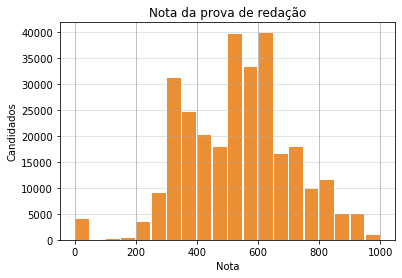

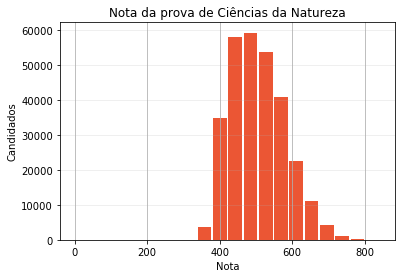

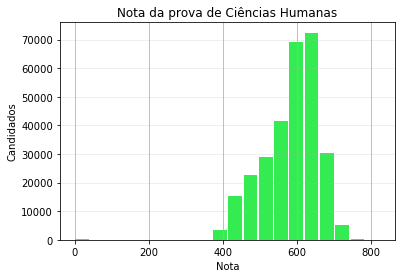

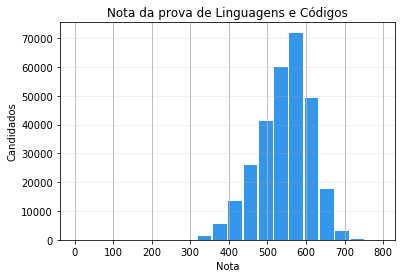

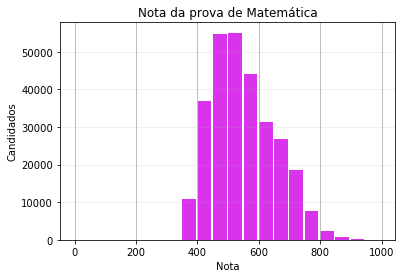

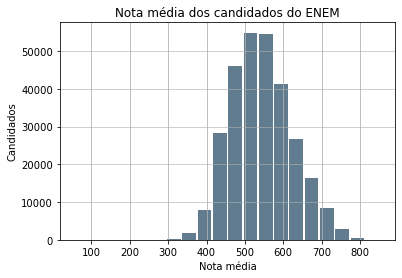

In [414]:
data['NU_NOTA_REDACAO'].plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#eb8f34')
plt.title('Nota da prova de redação')
plt.xlabel('Nota')
plt.ylabel('Candidados')
plt.grid(axis='y', alpha=0.45)
plt.show()

data['NU_NOTA_CN'].plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#eb5634')
plt.title('Nota da prova de Ciências da Natureza')
plt.xlabel('Nota')
plt.ylabel('Candidados')
plt.grid(axis='y', alpha=0.25)
plt.show()

data['NU_NOTA_CH'].plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#34eb52')
plt.title('Nota da prova de Ciências Humanas')
plt.xlabel('Nota')
plt.ylabel('Candidados')
plt.grid(axis='y', alpha=0.25)
plt.show()


data['NU_NOTA_LC'].plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#3496eb')
plt.title('Nota da prova de Linguagens e Códigos')
plt.xlabel('Nota')
plt.ylabel('Candidados')
plt.grid(axis='y', alpha=0.25)
plt.show()


data['NU_NOTA_MT'].plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#d934eb')
plt.title('Nota da prova de Matemática')
plt.xlabel('Nota')
plt.ylabel('Candidados')
plt.grid(axis='y', alpha=0.25)
plt.show()



data['NU_NOTA_TOTAL'].plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('Nota média dos candidados do ENEM')
plt.xlabel('Nota média')
plt.ylabel('Candidados')
plt.grid(axis='y', alpha=0.75)
plt.show()


# MLP

In [415]:
from pandas.plotting import scatter_matrix
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, roc_auc_score, classification_report

from keras.models import Sequential
from keras.utils import np_utils
from keras.regularizers import l1_l2
from keras.layers.core import Dense, Activation, Dropout
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split, GridSearchCV


## Divisão do dataset

A busca de hiperparâmetros será feita com o dataset de treinamento, que corresponde a 60% do total do conjunto. O k-fold cross validation com 5 folds utilizará apenas a parte destinada ao treinamento. Ao término da busca pelo hiperparâmetro, um novo classificador é construído e treinado utilizando o dataset de treinamento, 60% e o de validação que possui 15% do total de amostras. Finalmente é utilizado o dataset de testes para a obtenção do resultado final.

### Busca de hiperparâmetros
Será feita uma busca pelos melhores hiperparâmetros para o modelo. A métrica escolhida será a acurácia.

|Hiperparâmetro|Valores|
|:------------:|:------:|
|Neurônios|1, 5, 10, 15, 20, 25, 30, 50|
|Dropout|0.05, 0.10, 0.15|

#### Características do modelo

|||
|:-----:|:------:|
|Otimizador|Adam|
|Camadas escondidas|2|
|Função de ativação, camdas escondidas|relu|
|Função de ativação, camada de saída|sigmoid|
|Função de custo|binary_crossentropy|
|Inicialização dos pesos|uniform|




In [416]:
one_hot_cols = set(data.columns).intersection(one_hot_socio + one_hot_participante + one_hot_prova)
input_cols_ = set(input_cols).intersection(data.columns)

# Dataframe de entrada
df_inp = pandas.get_dummies(data[input_cols_], 
                   columns=set(one_hot_cols).intersection(input_cols_)
           ).replace({**encode_participante, **encode_socio})

# Dataframe de saída
df_out = data['NU_NOTA_TOTAL'].apply(encode_nota)

df_inp_train, df_inp_test, df_out_train, df_out_test = \
    train_test_split(df_inp,df_out, test_size=0.25, random_state=1)

df_inp_train, df_inp_val, df_out_train, df_out_val = \
    train_test_split(df_inp_train, df_out_train, test_size=0.20, random_state=1)

for col in df_inp.columns:
    if df_inp[col].dtype != 'uint8' and df_inp[col].dtype != 'int64':
        print(col, df_inp[col].dtype)

NU_IDADE float64
Q005 float64


#### Desbalanceamento
Após a codificação dos dados de saída, é possível observar o desbalanceamento das classes. A fim de minimizar os impactos
negativos no processo de trinamento, os pesos de cada classe foram ajustados para que ambas impactem de forma similar.

A classe "1", no caso a minoritária, terá seu peso alterado conforme a relação de desbalanceamento do dataset de testes.

In [417]:
print('Participantes acima da média: {}'.format(( df_out_train  == 1).sum()))
print('Participantes abaixo da média: {}'.format(( df_out_train  == 0).sum()))
class_weight = {0: 1., 1: (df_out_train == 0).sum()/(df_out_train == 1).sum()}
class_weight

Participantes acima da média: 40538
Participantes abaixo da média: 133186


{0: 1.0, 1: 3.2854605555281466}

In [419]:
def get_model(neurons=30, dropout=0.1):
    model = Sequential()
    kernel_initializer='uniform'
    optimizer='adam'
    
    # Camada Entrada
    model.add(Dense(neurons, input_dim=df_inp_train.shape[1], kernel_initializer=kernel_initializer))
    model.add(Dropout(dropout))
    model.add(Activation('relu'))
 
    model.add(Dense(neurons, kernel_initializer=kernel_initializer))
    model.add(Dropout(dropout))
    model.add(Activation('relu'))
  
    # Camada Saída
    model.add(Dense(output_dim=1, kernel_initializer=kernel_initializer))
    model.add(Dropout(dropout))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer,  metrics=['accuracy'])
    return model

In [ ]:
# create model 
keras_model = KerasClassifier(build_fn=get_model, epochs=50, batch_size=1000)
 
# define the grid search parameters
param_grid = {
    'neurons':[1, 5, 10, 15, 20, 25, 30, 50],
    'dropout':[0.1, 0.15, 0.25]
}

grid = GridSearchCV(estimator=keras_model, param_grid=param_grid, verbose=0, n_jobs=-1, cv=5, scoring='accuracy')

grid_result = grid.fit(df_inp_train, df_out_train, class_weight=class_weight)


#### Resultados da busca por hiperparâmetros

O melhort conjunto para a busca, com k-fold cross validation de 5 folds apresentou acurácia de acurácia 0.701616.

* Dropout 0.1
* Neurônios por camada 20
* Épocas 50
* Batch 1000

In [421]:
# summarize results
print("Melhor: acurácia %f com %s\n\n" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) com: %r" % (mean, stdev, param))

Melhor: acurácia 0.743288 com {'dropout': 0.1, 'neurons': 20}


0.539971 (0.252919) com: {'dropout': 0.1, 'neurons': 1}
0.739973 (0.007482) com: {'dropout': 0.1, 'neurons': 5}
0.741371 (0.003848) com: {'dropout': 0.1, 'neurons': 10}
0.736346 (0.003711) com: {'dropout': 0.1, 'neurons': 15}
0.743288 (0.004468) com: {'dropout': 0.1, 'neurons': 20}
0.733739 (0.006019) com: {'dropout': 0.1, 'neurons': 25}
0.741711 (0.008425) com: {'dropout': 0.1, 'neurons': 30}
0.738067 (0.008815) com: {'dropout': 0.1, 'neurons': 50}
0.659851 (0.214592) com: {'dropout': 0.15, 'neurons': 1}
0.734786 (0.005542) com: {'dropout': 0.15, 'neurons': 5}
0.736968 (0.008271) com: {'dropout': 0.15, 'neurons': 10}
0.739788 (0.006885) com: {'dropout': 0.15, 'neurons': 15}
0.739823 (0.007278) com: {'dropout': 0.15, 'neurons': 20}
0.741095 (0.005768) com: {'dropout': 0.15, 'neurons': 25}
0.735995 (0.011848) com: {'dropout': 0.15, 'neurons': 30}
0.739149 (0.005028) com: {'dropout': 0.15, 'neurons': 50}
0.663742 (0.215011) 

## Treinamento com Keras
Uma vez selecionado o modelo de melhor performance, o modelo é treinado novamente, agora com o dataset completo. Será utilizada a técnica de parada prematura, em que os pesos correspondentes ao menor custo de validação serão utilizados.

In [425]:
keras_model = class_pred = grid.best_estimator_.model

In [ ]:
callbacks = [
    ModelCheckpoint('mlp-neurons', monitor='val_loss', save_best_only=True, verbose=1)
]
print("Training...")
history = keras_model.fit(df_inp_train, df_out_train, validation_data=(df_inp_val, df_out_val),\
    class_weight=class_weight, callbacks=callbacks, epochs=50, batch_size=1000, verbose=1, shuffle=True, use_multiprocessing=True)

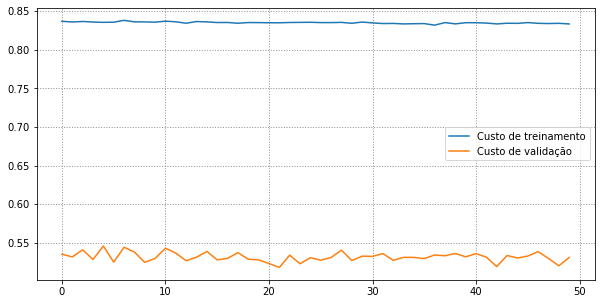

In [427]:
fig = plt.figure(figsize=(10,5))
plt.grid(color='#919191', linestyle=':', linewidth=1)
plt.plot(history.history['loss'], label='Custo de treinamento')
plt.plot(history.history['val_loss'], label='Custo de validação')
plt.grid(True)
plt.legend()
fig.savefig('mlp_history.png', dpi=600)
plt.show()


#### Parada prematura
Os pesos utilizados são referentes à época 6, que apresentou menor valor para a função de custo no dataset de validação 0.52507.

A acurácia para o dataset de treinamento foi 0.7415 enquanto para o dataset de validação 0.7301.



In [428]:
keras_model.load_weights('mlp-neurons')
class_pred = keras_model.predict_classes(df_inp_test)
print(classification_report(df_out_test, class_pred))

              precision    recall  f1-score   support

           0       0.89      0.77      0.82     55483
           1       0.48      0.70      0.57     16903

    accuracy                           0.75     72386
   macro avg       0.68      0.73      0.69     72386
weighted avg       0.79      0.75      0.76     72386



### Resultados

O classificador obteve resultados satisfatórios em relação à classe $0$, que representa alunos com nota média abaixo de 600. A classe $1$, que representa alunos com nota acima de 600, não obteve resultados satisfatórios, principalmente se a precisão for a métrica principal a ser avaliada. 

O classificador, para o dataset de testes, apresentou:

|              |precision  |  recall | f1-score |  amostras|
|:------------:|:---------:|:-------:|:--------:|:--------:|
|           0  |     0.89    |  0.77    |  0.82 |    55483|
|           1  |     0.48    |  0.70    |  0.57 |    16903|
|              |              |          |        |         |
|    accuracy  |            |           |  0.75  |   72386|
|   macro avg   |    0.68   |   0.73    |  0.69  |   72386|
|weighted avg    |   0.79   |   0.75    |  0.76  |   72386|

In [430]:
df_inp_test.shape

(72386, 105)